# Classification

The goal of classification is to find a function that separates the data into positive/negative labels. In the case of a linear classifier, this reduces to finding a set of parameters $w^\star$ such that, $$ \begin{align} w^\star &= \arg \min_w \sum_{i=1}^{N} \left[y_i\neq \text{sign} (w^\top x_i) \right] \\ &= \arg \min_w \sum_{i=1}^{N} l_{0/1} (w; x_i, y_i) \end{align}.$$ 

The problem with the $l_{0/1}$ loss, is that it is non-convex (and non-differentiable), hence other surrogate losses must be used to optimize the number of points. 

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from util import gradient_descent, generate_linear_separable_data, generate_circular_separable_data
import plot_helpers
import IPython

% load_ext autoreload
% autoreload 2
import ipywidgets
from ipywidgets import interact, interactive, interact_manual

import pylab
pylab.rcParams['figure.figsize'] = (10, 5)

from classifiers import Perceptron, SVM, Logistic
from regularizers import L1Regularizer, L2Regularizer


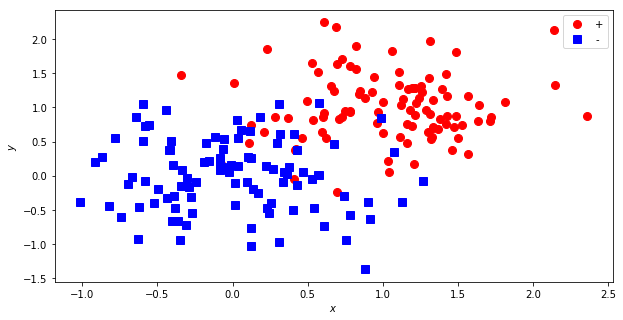

In [2]:
num_points = 100  # Number of points per class
noise = 0.5  # Noise Level (needed for data generation).

X, Y = generate_linear_separable_data(num_points, noise=noise, dim=2)

fig = plt.subplot(111)
opt = {'marker': 'ro', 'label': '+', 'size': 8}
plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
opt = {'marker': 'bs', 'label': '-', 'x_label': '$x$', 'y_label': '$y$', 'size': 8, 'legend': True}
plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)


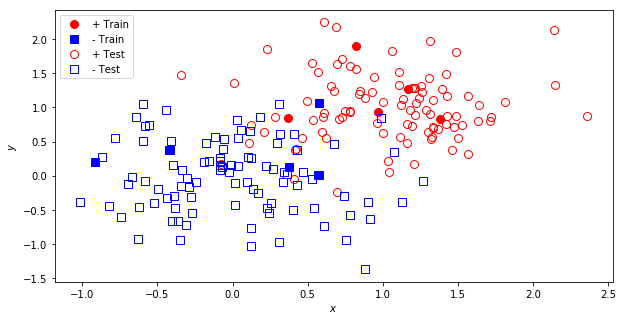

In [3]:
# Separate into train and test sets!
np.random.seed(42)
indexes = np.arange(0, 2*num_points, 1)
np.random.shuffle(indexes)
num_train = int(np.ceil(2*.05*num_points))

X_train = X[indexes[:num_train]]
Y_train = Y[indexes[:num_train]]

X_test = X[indexes[num_train:]]
Y_test = Y[indexes[num_train:]]

fig = plt.subplot(111)

opt = {'marker': 'ro', 'fillstyle': 'full', 'label': '+ Train', 'size': 8}
plot_helpers.plot_data(X_train[np.where(Y_train == 1)[0], 0], X_train[np.where(Y_train == 1)[0], 1], fig=fig, options=opt)
opt = {'marker': 'bs', 'fillstyle': 'full', 'label': '- Train', 'size': 8}
plot_helpers.plot_data(X_train[np.where(Y_train == -1)[0], 0], X_train[np.where(Y_train == -1)[0], 1], fig=fig, options=opt)

opt = {'marker': 'ro', 'fillstyle': 'none', 'label': '+ Test', 'size': 8}
plot_helpers.plot_data(X_test[np.where(Y_test == 1)[0], 0], X_test[np.where(Y_test == 1)[0], 1], fig=fig, options=opt)
opt = {'marker': 'bs', 'fillstyle': 'none', 'label': '- Test', 'size': 8, 
       'x_label': '$x$', 'y_label': '$y$', 'legend': True}
plot_helpers.plot_data(X_test[np.where(Y_test == -1)[0], 0], X_test[np.where(Y_test == -1)[0], 1], fig=fig, options=opt)


## The Perceptron Algorithm

The perceptron loss is defined as: $$L(w; X, Y) =  \sum_{i=1}^{N} L_p(w; x_i, y_i) = \sum_{i=1}^{N} \max \{ 0, -y_i w^\top x_i \}.$$

The loss function is continuous, but not differentialbe at $y_i w^\top x_i=0$. The subgradient, however, exists and hence (stochastic) gradient descent converges. The subgradient is:

$$ \partial L_p(w; x_i,y_i) = \left\{\begin{array}{cc} 0 & \text{if } -y_i w^\top x_i < 0 \\ -y_i x_i & \text{if } -y_i w^\top x_i > 0 \\ \left[0, -y_i x_i \right] & \text{if } -y_i w^\top x_i = 0 \end{array}  \right. $$

interactive(children=(FloatSlider(value=-3.0, continuous_update=False, description='Regularization 10^:', max=3.0, min=-3.0, readout_format='.1f', step=0.5, style=SliderStyle(description_width='initial')), FloatSlider(value=1.0, continuous_update=False, description='Learning rate:', max=2.0, min=0.1, readout_format='.1f', style=SliderStyle(description_width='initial')), IntSlider(value=100, continuous_update=False, description='Number of iterations:', min=5, style=SliderStyle(description_width='initial')), IntSlider(value=1, continuous_update=False, description='Batch Size:', max=10, min=1, style=SliderStyle(description_width='initial')), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

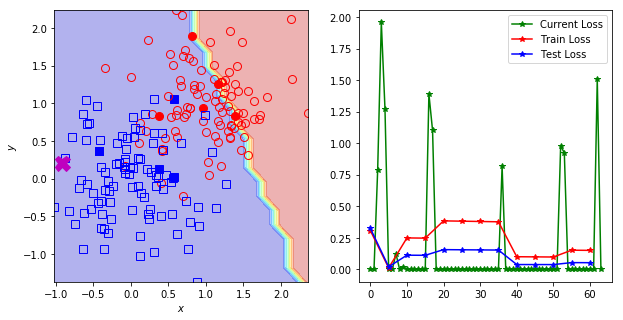

In [4]:
def change_learning_params(reg, eta0, n_iter, batch_size):
    classifier = Perceptron(X_train, Y_train)
    classifier.load_test_data(X_test, Y_test)
    
    regularizer = L2Regularizer(np.power(10., reg))
    np.random.seed(42)
    w0 = np.random.randn(3, )

    opts = {'eta0': eta0,
            'n_iter': n_iter,
            'batch_size': batch_size,
            'n_samples': X_train.shape[0],
            'algorithm': 'SGD',
            'learning_rate_scheduling': None,
            }
    trajectory, indexes = gradient_descent(w0, classifier, regularizer, opts)

    contour_plot = plt.subplot(121)
    error_plot = plt.subplot(122)
    
    opt = {'marker': 'ro', 'fillstyle': 'full', 'label': '+ Train', 'size': 8}
    plot_helpers.plot_data(X_train[np.where(Y_train == 1)[0], 0], X_train[np.where(Y_train == 1)[0], 1], fig=contour_plot, options=opt)
    opt = {'marker': 'bs', 'fillstyle': 'full', 'label': '- Train', 'size': 8}
    plot_helpers.plot_data(X_train[np.where(Y_train == -1)[0], 0], X_train[np.where(Y_train == -1)[0], 1], fig=contour_plot, options=opt)

    opt = {'marker': 'ro', 'fillstyle': 'none', 'label': '+ Test', 'size': 8}
    plot_helpers.plot_data(X_test[np.where(Y_test == 1)[0], 0], X_test[np.where(Y_test == 1)[0], 1], fig=contour_plot, options=opt)
    opt = {'marker': 'bs', 'fillstyle': 'none', 'label': '- Test', 'size': 8}
    plot_helpers.plot_data(X_test[np.where(Y_test == -1)[0], 0], X_test[np.where(Y_test == -1)[0], 1], fig=contour_plot, options=opt)

    contour_opts = {'n_points': 50, 'x_label': '$x$', 'y_label': '$y$', 'sgd_point': True, 'n_classes': 4}
    error_opts = {'epoch': 5, 'x_label': '$t$', 'y_label': 'error'}
    
    opts = {'contour_opts': contour_opts, 'error_opts': error_opts}
    plot_helpers.classification_progression(X, Y, trajectory, indexes, classifier, 
                                            contour_plot=contour_plot, error_plot=error_plot, 
                                            options=opts)

interact_manual(change_learning_params,
                reg=ipywidgets.FloatSlider(value=-3,
                                    min=-3,
                                    max=3,
                                    step=0.5,
                                    readout_format='.1f',
                                    description='Regularization 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False), 
                eta0=ipywidgets.FloatSlider(value=1,
                                            min=1e-1,
                                            max=2,
                                            step=1 * 1e-1,
                                            readout_format='.1f',
                                            description='Learning rate:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                n_iter=ipywidgets.IntSlider(value=100,
                                            min=5,
                                            max=100,
                                            step=1,
                                            description='Number of iterations:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                batch_size=ipywidgets.IntSlider(value=1,
                                            min=1,
                                            max=X_train.shape[0],
                                            step=1,
                                            description='Batch Size:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False)
               );

## The SVM Algorithm

The svm loss is defined as: $$L(w; X, Y) =  \sum_{i=1}^{N} L_{\text{svm}} (w; x_i, y_i) =  \sum_{i=1}^{N} \max \{ 0, 1-y_i w^\top x_i \}.$$

The loss function is continuous, but not differentialbe at $y_i w^\top x_i=0$. The subgradient, however, exists and hence (stochastic) gradient descent converges. The subgradient is:

$$ \partial L_{\text{svm}}(w;x_i,y_i) = \left\{\begin{array}{cc} 0 & \text{if } 1-y_i w^\top x_i < 0 \\ -y_i x_i & \text{if } 1-y_i w^\top x_i > 0 \\ \left[0, -y_i x_i \right] & \text{if } 1-y_i w^\top x_i = 0 \end{array}  \right. $$

The difference with the perceptron loss is that the SVM loss includes a loss margin. 

In [5]:
def change_learning_params(reg, eta0, n_iter, batch_size):
    classifier = SVM(X_train, Y_train)
    classifier.load_test_data(X_test, Y_test)
    
    regularizer = L2Regularizer(np.power(10., reg))
    np.random.seed(42)
    w0 = np.random.randn(3, )

    opts = {'eta0': eta0,
            'n_iter': n_iter,
            'batch_size': batch_size,
            'n_samples': X_train.shape[0],
            'algorithm': 'SGD',
            'learning_rate_scheduling': None
            }

    trajectory, indexes = gradient_descent(w0, classifier, regularizer, opts)
    
    contour_plot = plt.subplot(121)
    error_plot = plt.subplot(122)
    
    opt = {'marker': 'ro', 'fillstyle': 'full', 'label': '+ Train', 'size': 8}
    plot_helpers.plot_data(X_train[np.where(Y_train == 1)[0], 0], X_train[np.where(Y_train == 1)[0], 1], fig=contour_plot, options=opt)
    opt = {'marker': 'bs', 'fillstyle': 'full', 'label': '- Train', 'size': 8}
    plot_helpers.plot_data(X_train[np.where(Y_train == -1)[0], 0], X_train[np.where(Y_train == -1)[0], 1], fig=contour_plot, options=opt)

    opt = {'marker': 'ro', 'fillstyle': 'none', 'label': '+ Test', 'size': 8}
    plot_helpers.plot_data(X_test[np.where(Y_test == 1)[0], 0], X_test[np.where(Y_test == 1)[0], 1], fig=contour_plot, options=opt)
    opt = {'marker': 'bs', 'fillstyle': 'none', 'label': '- Test', 'size': 8}
    plot_helpers.plot_data(X_test[np.where(Y_test == -1)[0], 0], X_test[np.where(Y_test == -1)[0], 1], fig=contour_plot, options=opt)

    contour_opts = {'n_points': 100, 'x_label': '$x$', 'y_label': '$y$', 'sgd_point': True, 'n_classes': 4}
    error_opts = {'epoch': 5, 'x_label': '$t$', 'y_label': 'error'}
    
    opts = {'contour_opts': contour_opts, 'error_opts': error_opts}
    plot_helpers.classification_progression(X, Y, trajectory, indexes, classifier, 
                                            contour_plot=contour_plot, error_plot=error_plot, 
                                            options=opts)

interact_manual(change_learning_params,
                reg=ipywidgets.FloatSlider(value=-3,
                                    min=-3,
                                    max=3,
                                    step=0.5,
                                    readout_format='.1f',
                                    description='Regularization 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False), 
                eta0=ipywidgets.FloatSlider(value=1,
                                            min=1e-1,
                                            max=2,
                                            step=1 * 1e-1,
                                            readout_format='.1f',
                                            description='Learning rate:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                n_iter=ipywidgets.IntSlider(value=50,
                                            min=5,
                                            max=100,
                                            step=1,
                                            description='Number of iterations:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                batch_size=ipywidgets.IntSlider(value=1,
                                            min=1,
                                            max=X_train.shape[0],
                                            step=1,
                                            description='Batch Size:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False)
               );

interactive(children=(FloatSlider(value=-3.0, continuous_update=False, description='Regularization 10^:', max=3.0, min=-3.0, readout_format='.1f', step=0.5, style=SliderStyle(description_width='initial')), FloatSlider(value=1.0, continuous_update=False, description='Learning rate:', max=2.0, min=0.1, readout_format='.1f', style=SliderStyle(description_width='initial')), IntSlider(value=50, continuous_update=False, description='Number of iterations:', min=5, style=SliderStyle(description_width='initial')), IntSlider(value=1, continuous_update=False, description='Batch Size:', max=10, min=1, style=SliderStyle(description_width='initial')), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## The Logistic Regression Algorithm

The logistic loss is defined as: $$L(w; X, Y) = \sum_{i=1}^{N} L_{\sigma}(w; x_i, y_i) = \sum_{i=1}^{N} \log \left( 1 + \exp \left(-y_i w^\top x_i \right) \right) .$$

The loss function is differentiable, hence the gradient is:

$$ \frac{\partial L_{\sigma}(w; x_i, y_i)}{\partial w} = -\frac{\exp \left(-y_i w^\top x_i \right)}{1+\exp \left(-y_i w^\top x_i \right)} y x_i$$

In [ ]:
def change_learning_params(reg, eta0, n_iter, batch_size):
    classifier = Logistic(X_train, Y_train)
    classifier.load_test_data(X_test, Y_test)
    
    regularizer = L2Regularizer(np.power(10., reg))
    np.random.seed(42)
    w0 = np.random.randn(3, )

    opts = {'eta0': eta0,
            'n_iter': n_iter,
            'batch_size': batch_size,
            'n_samples': X_train.shape[0],
            'algorithm': 'SGD',
            'learning_rate_scheduling': 'AdaGrad'
            }

    trajectory, indexes = gradient_descent(w0, classifier, regularizer, opts)
    
    contour_plot = plt.subplot(121)
    error_plot = plt.subplot(122)
    
    opt = {'marker': 'ro', 'fillstyle': 'full', 'label': '+ Train', 'size': 8}
    plot_helpers.plot_data(X_train[np.where(Y_train == 1)[0], 0], X_train[np.where(Y_train == 1)[0], 1], fig=contour_plot, options=opt)
    opt = {'marker': 'bs', 'fillstyle': 'full', 'label': '- Train', 'size': 8}
    plot_helpers.plot_data(X_train[np.where(Y_train == -1)[0], 0], X_train[np.where(Y_train == -1)[0], 1], fig=contour_plot, options=opt)

    opt = {'marker': 'ro', 'fillstyle': 'none', 'label': '+ Test', 'size': 8}
    plot_helpers.plot_data(X_test[np.where(Y_test == 1)[0], 0], X_test[np.where(Y_test == 1)[0], 1], fig=contour_plot, options=opt)
    opt = {'marker': 'bs', 'fillstyle': 'none', 'label': '- Test', 'size': 8}
    plot_helpers.plot_data(X_test[np.where(Y_test == -1)[0], 0], X_test[np.where(Y_test == -1)[0], 1], fig=contour_plot, options=opt)

    contour_opts = {'n_points': 100, 'x_label': '$x$', 'y_label': '$y$', 'sgd_point': True, 'n_classes': 4}
    error_opts = {'epoch': 5, 'x_label': '$t$', 'y_label': 'error'}
    
    opts = {'contour_opts': contour_opts, 'error_opts': error_opts}
    plot_helpers.classification_progression(X, Y, trajectory, indexes, classifier, 
                                            contour_plot=contour_plot, error_plot=error_plot, 
                                            options=opts)

interact_manual(change_learning_params,
                reg=ipywidgets.FloatSlider(value=-3,
                                    min=-3,
                                    max=3,
                                    step=0.5,
                                    readout_format='.1f',
                                    description='Regularization 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False), 
                eta0=ipywidgets.FloatSlider(value=0.5,
                                            min=1e-1,
                                            max=2,
                                            step=1 * 1e-1,
                                            readout_format='.1f',
                                            description='Learning rate:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                n_iter=ipywidgets.IntSlider(value=100,
                                            min=5,
                                            max=50,
                                            step=1,
                                            description='Number of iterations:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                batch_size=ipywidgets.IntSlider(value=1,
                                            min=1,
                                            max=X_train.shape[0],
                                            step=1,
                                            description='Batch Size:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False)
               );

# Kernelized Classification

Both perceptron and SVM can be kernelized, i.e. the output of the regressor can be passed through the sign function. 

$$ \hat{y} = \text{sign} \left[ \sum_{i=1}^N \alpha_i y_i K(x_i, x) \right] $$ and a perceptron loss applied to the difference between the predictor and the true value. 

The perceptron loss can be posed as:

$$ L(\alpha;x_j, y_j) = \max \left\{0, -\sum_{j=1}^N y_j \alpha_i K(x_i, x_j) \right\} $$ 

The parameters are updated as follows: 
If $\hat{y}(x) \neq y(x)$, set $\alpha \gets \alpha + \eta_t$.  

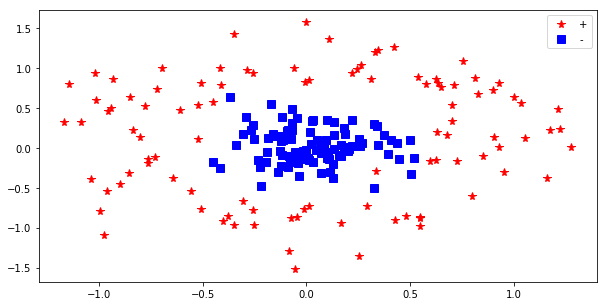

In [28]:
num_points = 100  # Number of points per class
noise = 0.2  # Noise Level (needed for data generation).

X, Y = generate_circular_separable_data(num_points, noise=noise, offset=1)
fig = plt.subplot(111)
opt = {'marker': 'r*', 'label': '+'}
plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
opt = {'marker': 'bs', 'label': '-'}
plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)
fig.legend();


In [32]:
from kernels import PolynomialKernel, LinearKernel, LaplacianKernel, GaussianKernel, GaussianLinearKernel, PeriodicKernel, PeriodicLinearKernel

def change_learning_params(eta0, n_iter, batch_size, kernel, deg):
    if kernel == 'Linear':
        classifier = PolynomialKernel(X, Y, reg=0.00, deg=1, prediction=False)
    elif kernel == 'Polynomial':
        classifier = PolynomialKernel(X, Y, reg=0.00, deg=deg, prediction=False)
    elif kernel == 'Gaussian':
        classifier = GaussianKernel(X, Y, reg=0.00, bw=0.2, prediction=False)   
    elif kernel == 'Laplacian':
        classifier = LaplacianKernel(X, Y, reg=0.00, bw=0.2, prediction=False)  
    
    regularizer = L2Regularizer(0.)
    
    alpha0 = 0 * np.random.randn(X.shape[0])

    opts = {'eta0': eta0,
            'n_iter': n_iter,
            'batch_size': batch_size,
            'n_samples': X.shape[0],
            'algorithm': 'SGD',
            'learning_rate_scheduling': None
            }
    alphas, indexes = gradient_descent(alpha0, classifier, regularizer, opts)

    fig = plt.subplot(111)
    opt = {'marker': 'r*', 'label': '+'}
    plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'bs', 'label': '-'}
    plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)

    contour_opts = {'n_points': 20, 'x_label': '$x$', 'y_label': '$y$', 'sgd_point': False, 'n_classes': 2}
    opts = {'contour_opts': contour_opts}
    plot_helpers.classification_progression(X, Y, alphas, indexes, classifier, contour_plot=fig, options=opts)

interact_manual(change_learning_params,
                eta0=ipywidgets.FloatSlider(value=0.5,
                                            min=1e-1,
                                            max=2,
                                            step=1 * 1e-1,
                                            readout_format='.1f',
                                            description='Learning rate:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                n_iter=ipywidgets.IntSlider(value=20,
                                            min=5,
                                            max=50,
                                            step=1,
                                            description='Number of iterations:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                batch_size=ipywidgets.IntSlider(value=X.shape[0],
                                            min=1,
                                            max=X.shape[0],
                                            step=1,
                                            description='Batch Size:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                kernel=ipywidgets.RadioButtons(
                             options=['Polynomial', 'Gaussian', 'Laplacian'],
                             value='Polynomial',
                             description='Kernel type:',
                             style={'description_width': 'initial'}),
                deg = ipywidgets.IntSlider(
                         value=1,
                         min=1,
                         max=10, 
                         step=1,
                         description='Degree of Polynomial kernel:',
                         style={'description_width': 'initial'}),
               );

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Learning rate:', max=2.0, min=0.1, readout_format='.1f', style=SliderStyle(description_width='initial')), IntSlider(value=20, continuous_update=False, description='Number of iterations:', max=50, min=5, style=SliderStyle(description_width='initial')), IntSlider(value=200, continuous_update=False, description='Batch Size:', max=200, min=1, style=SliderStyle(description_width='initial')), RadioButtons(description='Kernel type:', options=('Polynomial', 'Gaussian', 'Laplacian'), style=DescriptionStyle(description_width='initial'), value='Polynomial'), IntSlider(value=1, description='Degree of Polynomial kernel:', max=10, min=1, style=SliderStyle(description_width='initial')), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## SVM KERNELS
The SVM can also be kernelized! let's look at an example

In [26]:
def laplacian_kernel(X, Y, bw):
    rows = X.shape[0]
    cols = Y.shape[0]
    K = np.zeros((rows, cols))
    for col in range(cols):
        dist = bw * np.linalg.norm(X - Y[col, :], ord=1, axis=1)
        K[:, col] = np.exp(-dist)
    return K



In [27]:
from sklearn import svm
from sklearn import datasets
import sklearn

# Our dataset and targets
n_samples = 200  # Number of points per class
tol = 1e-1
# noise = 0.2  # Noise Level (needed for data generation).

# X, Y = generate_circular_separable_data(num_points, noise=noise, offset=1)
# X = X[:, 0:2]

def svm_kernel(dataset, kernel, reg, bw, deg, noise):
    if dataset is 'blobs':
        X, Y = datasets.make_blobs(n_samples=n_samples, centers=2, random_state=3, cluster_std=10*noise)
    elif dataset is 'circles':
        X, Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=noise, random_state=42)
    elif dataset is 'moons':
        X, Y = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=42)
    elif dataset == 'xor':
        np.random.seed(42)
        step = int(n_samples/4)
        
        X = np.zeros((n_samples, 2))
        Y = np.zeros(n_samples)
        
        X[0*step:1*step, :] = noise * np.random.randn(step, 2)
        Y[0*step:1*step] = 1
        X[1*step:2*step, :] = np.array([1, 1]) + noise * np.random.randn(step, 2)
        Y[1*step:2*step] = 1
        
        X[2*step:3*step, :] = np.array([0, 1]) + noise * np.random.randn(step, 2)
        Y[2*step:3*step] = -1
        X[3*step:4*step, :] = np.array([1, 0]) + noise * np.random.randn(step, 2)
        Y[3*step:4*step] = -1
    
    elif dataset == 'periodic':
        np.random.seed(42)
        step = int(n_samples/4)
        
        X = np.zeros((n_samples, 2))
        Y = np.zeros(n_samples)
        
        X[0*step:1*step, :] = noise * np.random.randn(step, 2)
        Y[0*step:1*step] = 1
        X[1*step:2*step, :] = np.array([0, 2]) + noise * np.random.randn(step, 2)
        Y[1*step:2*step] = 1
        
        X[2*step:3*step, :] = np.array([0, 1]) + noise * np.random.randn(step, 2)
        Y[2*step:3*step] = -1
        X[3*step:4*step, :] = np.array([0, 3]) + noise * np.random.randn(step, 2)
        Y[3*step:4*step] = -1
        
    X = X[Y <= 1, :]
    Y = Y[Y <=1 ]
    Y[Y==0] = -1
        
    # Add the 1 feature.  
    X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
    plot_support = True
    if kernel == 'poly':
        gamma = 1
        coef0 = 0
    elif kernel == 'sigmoid':
        gamma = np.power(10., bw)
        coef0 = 0
    elif kernel == 'rbf':
        gamma = np.power(10., -bw)
        coef0 = 0
    elif kernel == 'laplacian':
        gamma = np.power(10., -bw)
        coef0 = 0
        kernel = lambda X, Y: laplacian_kernel(X, Y, gamma)
        plot_support = False
    
    classifier = svm.SVC(kernel=kernel, C=np.power(10., -reg), gamma=gamma, degree=deg, coef0=coef0, tol=tol)
    classifier.fit(X, Y)

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure()
    plt.clf()
    fig = plt.axes()
    opt = {'marker': 'r*', 'label': '+'}
    plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'bs', 'label': '-'}
    plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)
    
    if plot_support:
        plt.scatter(classifier.support_vectors_[:, 0], classifier.support_vectors_[:, 1], s=80,
                    facecolors='none', edgecolors='k')

    mins = np.min(X, 0)
    maxs = np.max(X, 0)
    x_min = mins[0] - 1
    x_max = maxs[0] + 1
    y_min = mins[1] - 1
    y_max = maxs[1] + 1

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]  
    Xtest = np.c_[XX.ravel(), YY.ravel(), np.ones_like(XX.ravel())]
    # Xtest = np.c_[XX.ravel(), YY.ravel()]
    Z = classifier.decision_function(Xtest)

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    # plt.figure(fignum, figsize=(4, 3))
    plt.contourf(XX, YY, Z > 0, cmap=plt.cm.jet, alpha=0.3)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-.99, 0, .99])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

#     plt.xticks(())
#     plt.yticks(())

interact_manual(svm_kernel, 
        dataset=['blobs', 'circles', 'moons', 'xor', 'periodic'],
        kernel=['poly', 'rbf', 'laplacian'], 
        reg=ipywidgets.FloatSlider(value=-3,
                                    min=-3,
                                    max=3,
                                    step=0.5,
                                    readout_format='.1f',
                                    description='Regularization 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False),
        bw=ipywidgets.FloatSlider(value=-1,
                                    min=-3,
                                    max=3,
                                    step=0.1,
                                    readout_format='.1f',
                                    description='Bandwidth 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False),  
        deg=ipywidgets.IntSlider(
                         value=1,
                         min=1,
                         max=10, 
                         step=1,
                         description='Degree of Poly:',
                         style={'description_width': 'initial'}),
        noise=ipywidgets.FloatSlider(value=0.05,
                                    min=0.01,
                                    max=0.3,
                                    step=0.01,
                                    readout_format='.2f',
                                    description='Noise level:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False),  
        );

interactive(children=(Dropdown(description='dataset', options=('blobs', 'circles', 'moons', 'xor', 'periodic'), value='blobs'), Dropdown(description='kernel', options=('poly', 'rbf', 'laplacian'), value='poly'), FloatSlider(value=-3.0, continuous_update=False, description='Regularization 10^:', max=3.0, min=-3.0, readout_format='.1f', step=0.5, style=SliderStyle(description_width='initial')), FloatSlider(value=-1.0, continuous_update=False, description='Bandwidth 10^:', max=3.0, min=-3.0, readout_format='.1f', style=SliderStyle(description_width='initial')), IntSlider(value=1, description='Degree of Poly:', max=10, min=1, style=SliderStyle(description_width='initial')), FloatSlider(value=0.05, continuous_update=False, description='Noise level:', max=0.3, min=0.01, step=0.01, style=SliderStyle(description_width='initial')), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## KNN

The K-Nearest Neighbors classifier is very easy. The label of a next sample is the label most voted by the $k$ training samples that are closer to this sample.

A simple implementation is $$\hat{y} = \text{sign}\left\{\sum_{i \in \mathcal{N}_k (x)} K(x_i, x) y_i\right\},$$

where $\mathcal{N}_k (x)$ is the set with the $k$ closest neighbours of $x$, $K(x_i, x)$ is a weighting coefficient, and $y_i$ is the label of example $i$. Usually $K(\cdot, \cdot)$ can be a kernel function, that measures the similarity between two points. In the vanilla k-NN method the kernel is just the identity function. 
 


In [ ]:
from classifiers import kNN

noise = 0.4
X, Y = generate_circular_separable_data(num_points, noise=noise, offset=1)

def change_k_nn(k):
    classifier = kNN(X, Y, k)
    fig = plt.subplot(111)
    opt = {'marker': 'r*', 'label': '+'}
    plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'bs', 'label': '-'}
    plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)

    opt = {'n_points': 20, 'x_label': '$x$', 'y_label': '$y$'}
    plot_helpers.plot_classification_boundaries(X, classifier, fig=fig, options=opt)

interact(change_k_nn,
         k=ipywidgets.IntSlider(value=1,
                                min=1,
                                max=9,
                                step=2,
                                description='k',
                                style={'description_width': 'initial'},
                                continuous_update=False)
         );


# Cost Sensitivity

When there are more positive than negative examples the then, to overcome this uneven distribution of data, the cost of mislabeling can be changed between classes. 

The cost can be expressed as:  $$ w^\star = \arg \min_w \sum_{i=1}^{N} c(y_i) \left[y_i\neq \text{sign} (w^\top x_i) \right], $$ 
where $c(y_i)$ is a cost that depends on the class. 



In [4]:
num_positive = 20  # Number of points per class
num_negative = 100  # Number of points per class
noise = 0.3  # Noise Level (needed for data generation).

X, Y = generate_linear_separable_data(num_positive, num_negative, noise=noise, dim=2)
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

def cost_sensitivity(algorithm, ratio):
    class_weight = {-1: 1, 1:np.power(10., ratio)}
    if algorithm == 'SVM':
        classifier = LinearSVC(class_weight=class_weight)
    elif algorithm == 'Perceptron':
        classifier = SGDClassifier(loss='perceptron', random_state=1, class_weight=class_weight)

    classifier.fit(X[:,:2], Y)
    
    X0, X1 = X[:, 0], X[:, 1]
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = .02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    fig = plt.subplot(111)
    plot_helpers.plot_contours(fig, classifier, xx, yy, cmap=plt.cm.jet, alpha=0.3)
    opt = {'marker': 'r*', 'label': '+'}
    plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'bs', 'label': '-'}
    plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)

    
interact(cost_sensitivity,
         algorithm=ipywidgets.RadioButtons(
             options=['SVM', 'Perceptron'],
             value='SVM',
             description='Algorithm:',
             style={'description_width': 'initial'}),
         ratio=ipywidgets.FloatSlider(
             value=0,
             min=-1,
             max=3,
             step=0.5,
             description='Cost Ratio 10^:',
             style={'description_width': 'initial'},
             continuous_update=False)
         );

interactive(children=(RadioButtons(description='Algorithm:', options=('SVM', 'Perceptron'), style=DescriptionStyle(description_width='initial'), value='SVM'), FloatSlider(value=0.0, continuous_update=False, description='Cost Ratio 10^:', max=3.0, min=-1.0, step=0.5, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))

# L1 Regularization

The L-1 regularization method uses a regularizer of the form $R(w) = ||w||_1$ which is non-differentiable. However, the subgradient exits and is:

$$\partial(||w|||_1) = \left\{\begin{array}{cc} \text{sign} (w)& \text{if } w \neq 0 \\ [-1, 1]  & \text{if } w = 0 \end{array} \right. $$

This regularization method penalizes weights and induces sparsity in the solutions. That is, most of the entries of the solution $w^\star$ will be zero. 

In [ ]:
num_positive = 50  # Number of points per class
num_negative = 50  # Number of points per class

noise = 0.3  # Noise Level (needed for data generation).

X, Y = generate_linear_separable_data(num_positive, num_negative, offset=np.array([1, .2]), noise=noise, dim=2)
X = X - np.mean(X, axis=0)

from sklearn.linear_model import SGDClassifier

def regularization(regularizer, reg):
    np.random.seed(42)
    classifier = SGDClassifier(loss='perceptron', penalty=regularizer, alpha = np.power(10., reg), random_state=1)
    classifier.fit(X[:,:2], Y)
    
    X0, X1 = X[:, 0], X[:, 1]
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = .02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    fig = plt.subplot(111)
    contour = plot_helpers.plot_contours(fig, classifier, xx, yy, cmap=plt.cm.jet, alpha=0.3)
    plt.colorbar(contour)
    opt = {'marker': 'r*', 'label': '+'}
    plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'bs', 'label': '-', 'legend': True}
    plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)
    
interact(regularization,
         regularizer=ipywidgets.RadioButtons(
             options=['l1', 'l2'],
             value='l1',
             description='Algorithm:',
             style={'description_width': 'initial'}),
         reg=ipywidgets.FloatSlider(
             value=-3,
             min=-3,
             max=0,
             step=0.5,
             description='Regularizer 10^:',
             style={'description_width': 'initial'},
             continuous_update=False)
         );

# Multiclass Classification

In multiclass classification there are two strategies: OvO (One vs One) or OvR (One vs The Rest). 

In [ ]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

np.random.seed(1)
iris = datasets.load_iris()
X, y = iris.data[:,:2], iris.target
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

def multiclass(strategy):
    if strategy == 'OvO':
        classifier =  OneVsOneClassifier(SGDClassifier(loss='perceptron', alpha=0.001, n_iter=100, random_state=0))
#         classifier =  OneVsOneClassifier(LinearSVC(random_state=0))
        colors = ['g', 'r', 'b']
    elif strategy == 'OvR' or strategy == 'OvA':
        classifier =  OneVsRestClassifier(SGDClassifier(loss='perceptron', alpha=0.001, n_iter=100, random_state=0))
#         classifier =  OneVsRestClassifier(LinearSVC(random_state=0))
        colors = ['b', 'g', 'r']
        

    classifier.fit(X, y)
    X0, X1 = X[:, 0], X[:, 1]
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = .02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    fig = plt.subplot(111)
    plot_helpers.plot_contours(fig, classifier, xx, yy, cmap=plt.cm.jet, alpha=0.3)
    
    opt = {'marker': 'bs', 'label': '-', 'x_label': '$x$', 'y_label': '$y$', 'size': 8}
    plot_helpers.plot_data(X[np.where(y == 0)[0], 0], X[np.where(y == 0)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'g*', 'label': '+', 'size': 8}
    plot_helpers.plot_data(X[np.where(y == 1)[0], 0], X[np.where(y == 1)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'ro', 'label': '-', 'x_label': '$x$', 'y_label': '$y$', 'size': 8, 'legend': True}
    plot_helpers.plot_data(X[np.where(y == 2)[0], 0], X[np.where(y == 2)[0], 1], fig=fig, options=opt)
    

    def plot_hyperplane(clf, color):
        coef = clf.coef_
        intercept = clf.intercept_
        def line(x0):
            return (-(x0 * coef[0, 0]) - intercept[0]) / coef[0, 1]

        plt.plot([x_min, x_max], [line(x_min), line(x_max)],
                 ls="--", color=color)

    
    for estimator, color in zip(classifier.estimators_, colors):
        plot_hyperplane(estimator, color)

    fig.set_xlim([x_min, x_max])
    fig.set_ylim([y_min, y_max]);

interact(multiclass, strategy=['OvO', 'OvA']); 

# Multiclass with Nearest Neighbours

In [ ]:
from sklearn import neighbors

np.random.seed(1)
iris = datasets.load_iris()
X, y = iris.data[:,:2], iris.target

def change_n_neighbors(n_neighbors):
    for weights in ['uniform']:#, 'distance']:
        # we create an instance of Neighbours Classifier and fit the data.
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        clf.fit(X, y)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        h = 0.1
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure()
        fig = plt.axes()
        plt.contourf(xx, yy, Z, cmap=plt.cm.jet, alpha=0.3)
        
        # Plot also the training points
        opt = {'marker': 'bs', 'label': '-', 'x_label': '$x$', 'y_label': '$y$', 'size': 8}
        plot_helpers.plot_data(X[np.where(y == 0)[0], 0], X[np.where(y == 0)[0], 1], fig=fig, options=opt)
        opt = {'marker': 'g*', 'label': '+', 'size': 8}
        plot_helpers.plot_data(X[np.where(y == 1)[0], 0], X[np.where(y == 1)[0], 1], fig=fig, options=opt)
        opt = {'marker': 'ro', 'label': '-', 'x_label': '$x$', 'y_label': '$y$', 'size': 8, 'legend': True}
        plot_helpers.plot_data(X[np.where(y == 2)[0], 0], X[np.where(y == 2)[0], 1], fig=fig, options=opt)
        
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title("3-Class classification (k = %i, weights = '%s')"
                  % (n_neighbors, weights))
    
interact(change_n_neighbors, n_neighbors=ipywidgets.IntSlider(value=1, min=1, max=15, step=2));